In [9]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch 
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size
from tqdm.notebook import tqdm

from utils.utils import *
sr = 16000

#test


In [10]:
model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")
# print(torch.cuda.memory_summary())


Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.


/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8898.4404296875 MiB


In [ ]:
full_prompt = "Forest ambience with birds chirping and a gentle stream flowing"
duration = 30.0 

In [12]:
model.cond_stage_model.embed_mode = "text"

# 🎵 TEMPORAL PROMPT SEGMENTATION - Simple segments for crossfading
# TEMPORAL PROMPTS: Simple, separate segments for crossfading
duration = 30.0  # seconds

# Define time segments with simple, distinct prompts (NO combined concepts!)
prompt_segments = [
    (0.0, 30.0, "90s rock song with electric guitar and heavy drums"),
]

print("🎭 CREATING SIMPLE SEGMENT PROMPT EMBEDDINGS:")

# Create embeddings for ONLY the simple segments (no global/narrative prompt)
segment_embeddings = []
for start_time, end_time, segment_prompt in prompt_segments:
    text_list = [segment_prompt]
    segment_emb = model.get_learned_conditioning(text_list)
    segment_embeddings.append(segment_emb)
    print(f"  {start_time:4.1f}s - {end_time:4.1f}s: '{segment_prompt}'")

# Create unconditional embedding
unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)

print(f"✅ Created {len(segment_embeddings)} simple segment embeddings")
print("🔄 Strategy: Use crossfading between simple prompts (NO combined prompts)")


🎭 CREATING SIMPLE SEGMENT PROMPT EMBEDDINGS:
   0.0s - 30.0s: '90s rock song with electric guitar and heavy drums'
✅ Created 1 simple segment embeddings
🔄 Strategy: Use crossfading between simple prompts (NO combined prompts)


# End-to-End Text-to-Sound Pipeline

This notebook implements a **MultiDiffusion** extension of DDIM to generate long-form audio from text:

1. **Text → Embedding**: Convert prompt to conditioning vectors via CLAP.
2. **Latent Noise Initialization**: Sample `z` of shape `[1, C, T, F]`.
3. **Scheduler Setup (DDIM)**: Call `sampler.make_schedule()` for timesteps.
4. **MultiDiffusion Chunking** (75% overlap): Split latent along time into overlapping chunks.
5. **Per-Chunk U-Net**: Run model to predict noise for each padded chunk (with CFG).
6. **Overlap-Average**: Merge chunk noise predictions into one full tensor.
7. **Single-Tensor DDIM Step**: Apply DDIM reverse-diffusion math to full tensor.
8. **Repeat** for all timesteps → final latent `x_0`.
9. **VAE Decode**: `x_0` → mel-spectrogram via VAE.
10. **Vocoder**: Convert mel to waveform audio for playback.

---


DEBUG DURATION CONVERSION:
Requested duration: 30.0s
Latent size (time frames): 768
Latent shape: [1, 8, 768, 16]
Expected frames per second in latent space: 25.60
DEBUG: total_frames=768, chunk_size=256, overlap_frames=192, advance_step=64
DEBUG: chunk 1: (0, 256) - frames: 256
DEBUG: chunk 2: (64, 320) - frames: 256
DEBUG: chunk 3: (128, 384) - frames: 256
DEBUG: chunk 4: (192, 448) - frames: 256
DEBUG: chunk 5: (256, 512) - frames: 256
DEBUG: chunk 6: (320, 576) - frames: 256
DEBUG: chunk 7: (384, 640) - frames: 256
DEBUG: chunk 8: (448, 704) - frames: 256
DEBUG: chunk 9: (512, 768) - frames: 256
DEBUG: Created 9 chunks covering frames 0-768
LONG AUDIO: Using MultiDiffusion with 9 chunks, overlap=192
🔄 CLEAN BOUNDARIES: No crossfading, using standard overlap averaging

📊 EXPECTED CHUNK DISTRIBUTION:
  Segment 1: 0.0s-30.0s '90s rock song with electric guitar and heavy drums' → ~12 chunks expected
  Chunk 1: frames[0:256] time[0.0-10.0s] CENTER=5.0s -> '90s rock song with electric gu

Temporal Diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Temporal Diffusion: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s]

Diffusion time: 152.80s, peak mem: 4709.0 MiB, curr mem: 4462.3 MiB
Final latent shape: torch.Size([1, 8, 768, 16])
✅ Diffusion latent output is clean (no NaN/Inf)


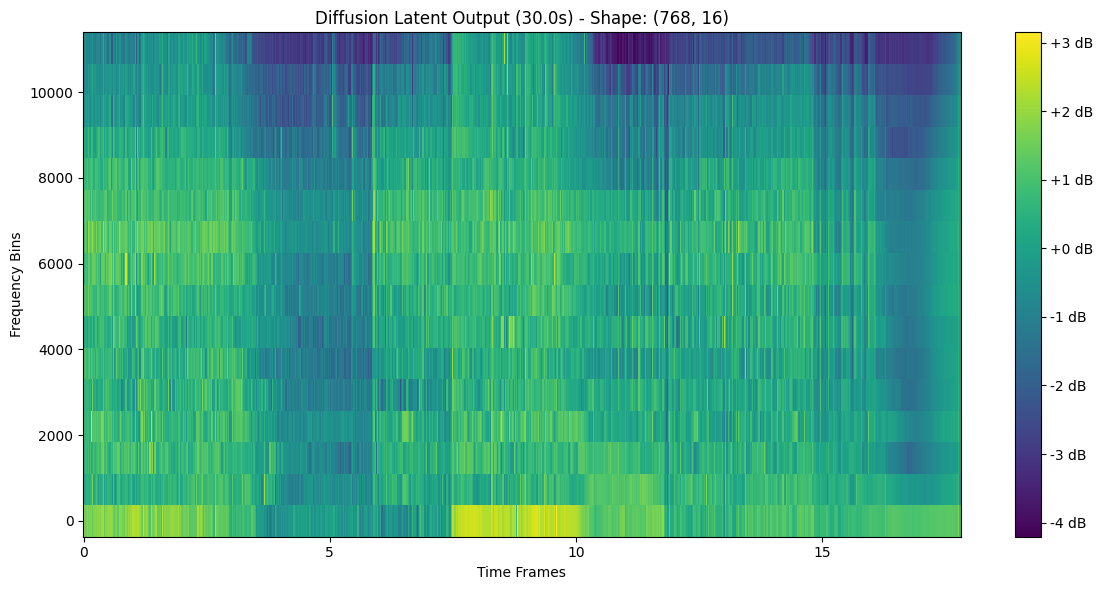

Latent stats - Min: -4.207, Max: 3.152, Mean: -0.066, Std: 1.069


In [13]:
# Run MultiDiffusion Diffusion Loop with Crossfading
## Set parameters
ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0
chunk_frames = 256
overlap_frames = int(chunk_frames * 0.75)

# Scheduler and initial noise
sampler = DDIMSampler(model)
latent_size = duration_to_latent_t_size(duration)
shape = [1, model.channels, latent_size, model.latent_f_size]
z = torch.randn(shape).to(model.device)

# Debug duration conversion
print(f"DEBUG DURATION CONVERSION:")
print(f"Requested duration: {duration}s")
print(f"Latent size (time frames): {latent_size}")
print(f"Latent shape: {shape}")
print(f"Expected frames per second in latent space: {latent_size / duration:.2f}")

# Memory & timing
memory_before_diffusion = torch.cuda.memory_allocated() / (1024*1024)
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

# Example debug chunk prints (keep these)
total_frames = latent_size
chunk_size = chunk_frames
advance_step = chunk_size - overlap_frames
num_chunks = (total_frames - overlap_frames) // advance_step
print(f"DEBUG: total_frames={total_frames}, chunk_size={chunk_size}, overlap_frames={overlap_frames}, advance_step={advance_step}")
for idx in range(num_chunks):
    start = idx * advance_step
    end = start + chunk_size
    print(f"DEBUG: chunk {idx+1}: ({start}, {end}) - frames: {chunk_size}")
print(f"DEBUG: Created {num_chunks} chunks covering frames 0-{total_frames}")
print(f"LONG AUDIO: Using MultiDiffusion with {num_chunks} chunks, overlap={overlap_frames}")
print(f"🔄 CLEAN BOUNDARIES: No crossfading, using standard overlap averaging")

# Expected chunk distribution analysis
print(f"\n📊 EXPECTED CHUNK DISTRIBUTION:")
for i, (seg_start, seg_end, seg_prompt) in enumerate(prompt_segments):
    expected_chunks = int((seg_end - seg_start) * 25.6 / advance_step)
    print(f"  Segment {i+1}: {seg_start}s-{seg_end}s '{seg_prompt}' → ~{expected_chunks} chunks expected")

with torch.no_grad():
    samples = multidiffusion_sample_temporal(
        sampler=sampler,
        shape=shape,
        segment_embeddings=segment_embeddings,
        prompt_segments=prompt_segments,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        x_T=z,
        S=ddim_steps,
        chunk_frames=chunk_frames,
        overlap_frames=overlap_frames,
        duration=duration
    )
torch.cuda.synchronize()

# Report performance
diffusion_time = time.time() - start_time
peak_mem = torch.cuda.max_memory_allocated() / (1024*1024)
curr_mem = torch.cuda.memory_allocated() / (1024*1024)
print(f"Diffusion time: {diffusion_time:.2f}s, peak mem: {peak_mem:.1f} MiB, curr mem: {curr_mem:.1f} MiB")

# Display final latent
print(f"Final latent shape: {samples.shape}")
check_for_nan_inf(samples, "Diffusion latent output")
plot_latent_spectrogram(samples, f"Diffusion Latent Output ({duration}s)")

🪟 USING SLIDING WINDOW VAE DECODER:
  Input shape: torch.Size([1, 8, 768, 16])
  Window size: 256 frames (~10.0s)
  Overlap size: 64 frames (~2.5s)
  Step size: 192 frames
  Number of windows: 4
    Window 1: latent[0:256] -> mel shape torch.Size([1, 1, 1024, 64])
    Window 2: latent[192:448] -> mel shape torch.Size([1, 1, 1024, 64])
    Window 3: latent[384:640] -> mel shape torch.Size([1, 1, 1024, 64])
    Window 4: latent[576:768] -> mel shape torch.Size([1, 1, 768, 64])
  Mel scale factor: 4.00x
  Output mel shape: [1, 1, 3072, 64]
    Added window 1 to output[0:1024]
    Added window 2 to output[768:1792]
    Added window 3 to output[1536:2560]
    Added window 4 to output[2304:3072]

📊 SLIDING WINDOW VAE PERFORMANCE:
SLIDING WINDOW VAE ISOLATED PEAK: 4720.1 MiB (cost: +257.9 MiB)
SLIDING WINDOW VAE CURRENT MEMORY: 4462.3 MiB
SLIDING WINDOW VAE TIME: 0.2s

🔍 SLIDING WINDOW VAE OUTPUT ANALYSIS:
Mel spectrogram shape: torch.Size([1, 1, 3072, 64])
Latent → Mel conversion factor: 4.0

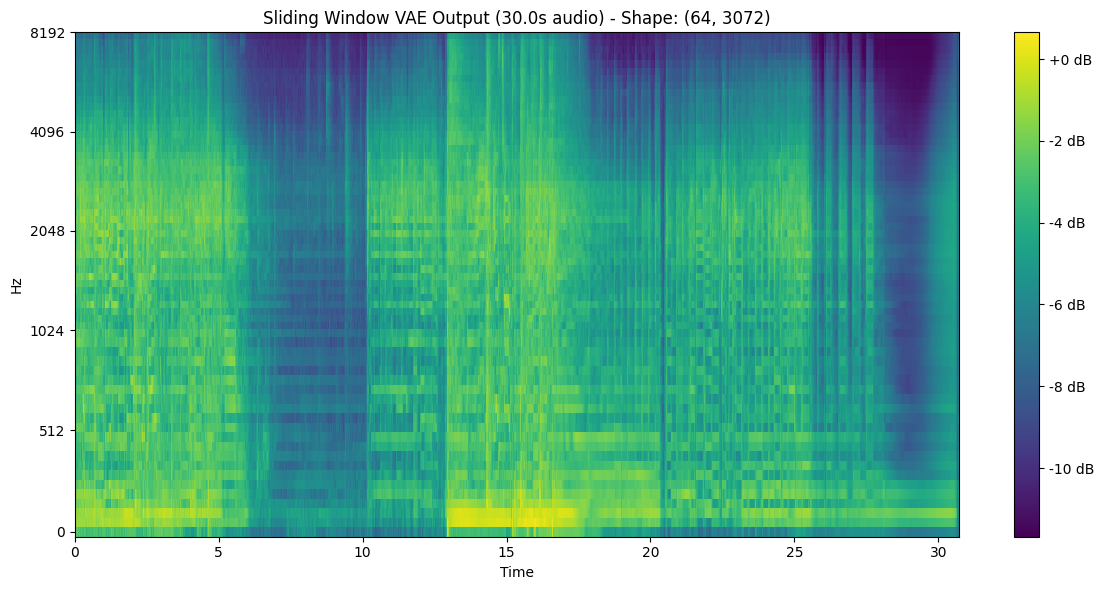

Mel stats - Min: -11.680, Max: 0.652, Mean: -4.990, Std: 2.224


In [14]:
# VAE DECODER - Using Sliding Window approach for memory efficiency
# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

print("🪟 USING SLIDING WINDOW VAE DECODER:")

# Define sliding window VAE function
def sliding_window_vae_decode(model, latents, window_size=256, overlap_size=64):
    """
    Decode latents using sliding windows with overlap-add reconstruction.
    
    Args:
        model: AudioLDM model with VAE decoder
        latents: Input latent tensor [B, C, T, F]
        window_size: Size of each window in latent frames (default: 256 ~= 10s)
        overlap_size: Overlap between windows in frames (default: 64 ~= 2.5s)
    
    Returns:
        Reconstructed mel spectrogram
    """
    device = latents.device
    B, C, T, F = latents.shape
    
    print(f"  Input shape: {latents.shape}")
    print(f"  Window size: {window_size} frames (~{window_size/25.6:.1f}s)")
    print(f"  Overlap size: {overlap_size} frames (~{overlap_size/25.6:.1f}s)")
    
    # If input is smaller than window, use regular decoding
    if T <= window_size:
        print(f"  Input smaller than window - using regular decode")
        return model.decode_first_stage(latents)
    
    # Calculate windows
    step_size = window_size - overlap_size
    num_windows = (T - overlap_size + step_size - 1) // step_size
    
    print(f"  Step size: {step_size} frames")
    print(f"  Number of windows: {num_windows}")
    
    # Process each window
    windows = []
    window_positions = []
    
    for i in range(num_windows):
        start = i * step_size
        end = min(start + window_size, T)
        actual_window_size = end - start
        
        # Extract window
        window_latent = latents[:, :, start:end, :]
        
        # Decode window
        with torch.no_grad():
            window_mel = model.decode_first_stage(window_latent)
        
        windows.append(window_mel)
        window_positions.append((start, end, actual_window_size))
        
        print(f"    Window {i+1}: latent[{start}:{end}] -> mel shape {window_mel.shape}")
    
    # Calculate output dimensions
    mel_scale_factor = windows[0].shape[2] / window_positions[0][2]  # mel_frames / latent_frames
    total_mel_frames = int(T * mel_scale_factor)
    mel_channels = windows[0].shape[1]
    mel_freq_bins = windows[0].shape[3]
    
    print(f"  Mel scale factor: {mel_scale_factor:.2f}x")
    print(f"  Output mel shape: [{B}, {mel_channels}, {total_mel_frames}, {mel_freq_bins}]")
    
    # Initialize output tensor and weight accumulator
    output_mel = torch.zeros((B, mel_channels, total_mel_frames, mel_freq_bins), 
                            device=device, dtype=windows[0].dtype)
    weight_sum = torch.zeros_like(output_mel)
    
    # Create overlap-add weights (linear fade in/out)
    overlap_mel_size = int(overlap_size * mel_scale_factor)
    
    for i, (window_mel, (start, end, actual_size)) in enumerate(zip(windows, window_positions)):
        # Calculate mel positions
        mel_start = int(start * mel_scale_factor)
        mel_end = int(end * mel_scale_factor)
        actual_mel_size = window_mel.shape[2]
        
        # Create weight mask for this window
        weight_mask = torch.ones((1, 1, actual_mel_size, 1), device=device)
        
        # Apply fade-in at the beginning (except for first window)
        if i > 0 and overlap_mel_size > 0:
            fade_in_size = min(overlap_mel_size, actual_mel_size // 2)
            fade_in = torch.linspace(0, 1, fade_in_size, device=device)
            weight_mask[:, :, :fade_in_size, :] = fade_in.view(1, 1, -1, 1)
        
        # Apply fade-out at the end (except for last window)
        if i < len(windows) - 1 and overlap_mel_size > 0:
            fade_out_size = min(overlap_mel_size, actual_mel_size // 2)
            fade_out = torch.linspace(1, 0, fade_out_size, device=device)
            weight_mask[:, :, -fade_out_size:, :] = fade_out.view(1, 1, -1, 1)
        
        # Add weighted window to output
        mel_end_actual = mel_start + actual_mel_size
        output_mel[:, :, mel_start:mel_end_actual, :] += window_mel * weight_mask
        weight_sum[:, :, mel_start:mel_end_actual, :] += weight_mask
        
        print(f"    Added window {i+1} to output[{mel_start}:{mel_end_actual}]")
    
    # Normalize by weight sum to complete overlap-add
    output_mel = output_mel / torch.clamp(weight_sum, min=1e-8)
    
    return output_mel

# Run Sliding Window VAE (replacing the regular decode_first_stage call)
start_time = time.time()
with torch.no_grad(): 
    mel_spectrogram = sliding_window_vae_decode(model, samples, window_size=256, overlap_size=64)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"\n📊 SLIDING WINDOW VAE PERFORMANCE:")
print(f"SLIDING WINDOW VAE ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"SLIDING WINDOW VAE CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"SLIDING WINDOW VAE TIME: {vae_time:.1f}s")

# 🔍 VAE DECODER OUTPUT ANALYSIS & VISUALIZATION
print(f"\n🔍 SLIDING WINDOW VAE OUTPUT ANALYSIS:")
print(f"Mel spectrogram shape: {mel_spectrogram.shape}")
print(f"Latent → Mel conversion factor: {mel_spectrogram.shape[2] / samples.shape[2]:.2f}x")
print(f"Mel frames: {mel_spectrogram.shape[2]}")
print(f"Expected mel duration: {mel_spectrogram.shape[2] / 100:.2f}s")  # Using 100 fps for AudioLDM
check_for_nan_inf(mel_spectrogram, "Sliding window VAE mel spectrogram output")

# Display mel spectrogram
print(f"\n📊 MEL SPECTROGRAM (from Sliding Window VAE):")
plot_mel_spectrogram(mel_spectrogram, f"Sliding Window VAE Output ({duration}s audio)", sr=sr)

In [15]:
# VOCODER - Using standard approach for now (will optimize later)
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)
    # Handle both PyTorch tensors and NumPy arrays
    if isinstance(waveform, torch.Tensor):
        if waveform.dim() > 1:
            waveform = waveform[0]  # Take first batch item: [B, samples] -> [samples]
        waveform = waveform.squeeze()  # Remove any extra dimensions
    else:  # NumPy array
        if waveform.ndim > 1:
            waveform = waveform[0]  # Take first batch item: [B, samples] -> [samples]
        waveform = waveform.squeeze()  # Remove any extra dimensions
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

print(f"\nFINAL RESULTS:")
print(f"Generated {duration}s audio with MultiDiffusion")
print(f"Audio shape: {waveform.shape}")
print(f"Audio duration (samples): {len(waveform) / sr:.1f}s")
print(f"Expected samples for {duration}s: {int(duration * sr)}")
print(f"Actual samples: {len(waveform)}")
print(f"Duration discrepancy: {(len(waveform) / sr) - duration:.3f}s")
print(f"Mel → Audio conversion factor: {len(waveform) / mel_spectrogram.shape[2]:.1f}x")
print(f"Overall latent → audio factor: {len(waveform) / samples.shape[2]:.1f}x")

ipd.display(ipd.Audio(waveform, rate=sr))


VOCODER ISOLATED PEAK: 4825.0 MiB (cost: +362.8 MiB)
VOCODER CURRENT MEMORY: 4462.3 MiB
VOCODER TIME: 0.2s

FINAL RESULTS:
Generated 30.0s audio with MultiDiffusion
Audio shape: (491552,)
Audio duration (samples): 30.7s
Expected samples for 30.0s: 480000
Actual samples: 491552
Duration discrepancy: 0.722s
Mel → Audio conversion factor: 160.0x
Overall latent → audio factor: 640.0x


In [16]:
import soundfile as sf

# Ensure waveform is a NumPy array and has the correct shape
waveform = waveform.squeeze()  # Remove batch dimension if present
if isinstance(waveform, torch.Tensor):
    waveform = waveform.cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor

# Save the generated audio to a file
output_path = "../output/generation"
os.makedirs(output_path, exist_ok=True)
filename = f"multi60%.wav"  # Simplify filename
sf.write(os.path.join(output_path, filename), waveform, sr)

print(f"Audio saved to {os.path.join(output_path, filename)}")

Audio saved to ../output/generation/multi60%.wav
